# Analiza drustvene mreže Reddit

Univerzitet u Beogradu, Elektrotehnički fakultet, veb adresa [ovde](https://www.etf.bg.ac.rs).  
Predmet: Analiza socijalnih mreža, veb adresa [ovde](https://rti.etf.bg.ac.rs/rti/ms1asm/).  
Tekst projektnog zadatka se može naći na veb sajtu predmeta [ovde](https://rti.etf.bg.ac.rs/rti/ms1asm/projekti/2021-2022/ASM_PZ2_2122.pdf).  
- Bogdan Bebić 2022/3051
- Marta Avramović 2022/3166

## Instalacija i učitavanje korišćenih biblioteka
Neophodne bilioteke se mogu instalirati korišćenjem Python package instalera `pip`.

In [1]:
import os
import networkx as nx
import numpy as np
import pandas as pd

## Format skupa podataka
Podaci su preuzeti sa sajta predmeta i otpakovani u odgovarajuće direktorijume.
Kako postoji više datoteka sa istim tipom podataka, učitavamo ih sve zajedno i spajamo u jedinstvenu strukturu podataka.

In [2]:
reddit_data_path = "ASM_PZ2_podaci_2122/reddit2008"
submission_dataPath = f"{reddit_data_path}/submissions_2008_asm/"
comments_dataPath = f"{reddit_data_path}/comments_2008_asm_v1.1/comments_2008/"


def loadDataSet(folderPath):
    allFileData = pd.DataFrame([])
    for fileName in os.listdir(folderPath):
        singleFileData = pd.read_csv(folderPath + fileName, low_memory=False)
        allFileData = pd.concat([allFileData, singleFileData])

    return allFileData


def groupby_count(data_frame, groupby_list):
    return data_frame.groupby(groupby_list).size().reset_index(name="counts")


def groupby_count_sorted(data_frame, groupby_list):
    return groupby_count(data_frame, groupby_list).sort_values('counts', ascending=False)

## Filtriranje skupa podataka
Na društvenoj mreži Reddit je moguće obrisati nalog - u tom slučaju se mogu dobiti podaci koji sadrže `[deleted]` kao korisničko ime.
Ovakvi podaci nepovoljno utiču na analizu jer su ti nalozi mogli pripadati proizvoljnom broju korisnika i stoga ih filtriramo i ne koristimo u daljoj analizi.

In [3]:
submissionData = loadDataSet(submission_dataPath)
commentsData = loadDataSet(comments_dataPath)

# It is possible to have "[deleted]" as author name
submissionFilter = submissionData["author"] != "[deleted]"
commentsFilter = commentsData["author"] != "[deleted]"

filteredSubmissions = submissionData[submissionFilter]
filteredComments = commentsData[commentsFilter]

allData = pd.concat([filteredSubmissions, filteredComments])

In [4]:
allSubredditIds = np.union1d(submissionData['subreddit_id'], commentsData['subreddit_id'])
print(f"Number of different subreddits: {len(allSubredditIds)}")

commentsPerSubreddit = groupby_count_sorted(commentsData, ["subreddit_id"])
print(f"Comments per subreddit:\n{commentsPerSubreddit[:1]}")

# subreddit - author - count interactions
interactionsPerAuthorPerSubreddit = groupby_count(allData, ["subreddit_id", "author"])
# subreddit - count authors
authorsPerSubreddit = groupby_count_sorted(interactionsPerAuthorPerSubreddit, ["subreddit_id"])
print(f"Authors per subreddit:\n{authorsPerSubreddit[:1]}")

print(f"AVG number users per subreddit:\n{authorsPerSubreddit['counts'].sum() / len(allSubredditIds)}")

submissionsPerAuthor = groupby_count_sorted(filteredSubmissions, ['author'])
commentsPerAuthor = groupby_count_sorted(filteredComments, ['author'])
print(f"Max submissions per author:\n{submissionsPerAuthor[:1]}")
print(f"Max comments per author:\n{commentsPerAuthor[:1]}")

# author - subreddit - count interactions
interactionsPerSubredditPerAuthor = groupby_count(allData, ['author', 'subreddit_id'])
# author - count subreddits
subredditsPerAuthor = groupby_count_sorted(interactionsPerSubredditPerAuthor, ['author'])
print(f"Subreddits per author:\n{subredditsPerAuthor[:1]}")

Number of different subreddits: 5032
Comments per subreddit:
     subreddit_id   counts
2689         t5_6  1884629
Authors per subreddit:
     subreddit_id  counts
4354         t5_6  163779
AVG number users per subreddit:
128.78398251192368
Max submissions per author:
      author  counts
84823    gst   18870
Max comments per author:
                author  counts
12603  NoMoreNicksLeft   13480
Subreddits per author:
         author  counts
26173  MrKlaatu     181


Pearson correlation matrix:
                    counts_submissions  counts_comments
counts_submissions            1.000000         0.150412
counts_comments               0.150412         1.000000


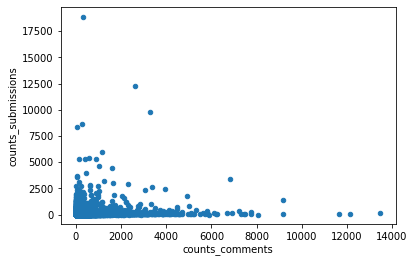

In [5]:
paersonCalculation = submissionsPerAuthor.copy().merge(commentsPerAuthor.copy(), on="author", how="inner", suffixes=["_submissions", "_comments"])
paersonCalculation.plot.scatter(y="counts_submissions", x="counts_comments")
print(f"Pearson correlation matrix:\n{paersonCalculation.corr(method='pearson')}")

In [6]:
filterNonOver18 = submissionData["over_18"] == False
filteredSubmissionsNonOver18 = submissionData[filterNonOver18]
extractedCommentsData = pd.DataFrame(commentsData["link_id"].map(lambda element: element.split("_")[1]))
commentsDataSubmissionId = groupby_count_sorted(extractedCommentsData, ["link_id"]).rename(columns={"link_id": "id"})
filteredSubmissionsNonOver18JoinedComments = filteredSubmissionsNonOver18.merge(commentsDataSubmissionId, how="inner", on="id")
print(filteredSubmissionsNonOver18JoinedComments.sort_values(by="counts", ascending=False)[:10])

        Unnamed: 0     id                                                url  \
290534      191390  7kpe5  https://www.reddit.com/r/AskReddit/comments/7k...   
574617      111467  6nz1k                          http://hundredpushups.com   
57505       135995  675oj  https://www.reddit.com/r/reddit.com/comments/6...   
942221      191265  78n1v  http://www.time.com/time/nation/article/0,8599...   
133696       36220  7beo2  https://www.reddit.com/r/politics/comments/7be...   
488720       73206  6jbc0  https://www.reddit.com/r/reddit.com/comments/6...   
764729      197408  6yn6t                   http://www.cnbc.com/id/26454655?   
721214       84267  6w7e6  https://www.reddit.com/r/reddit.com/comments/6...   
136018       41921  7bj3f  http://www.latimes.com/news/local/la-me-gaymar...   
772368        4466  6z2e2  http://www.nytimes.com/reuters/us/internationa...   

                                                permalink        author  \
290534  /r/AskReddit/comments/7kpe5/i_am_con

## Modelovanje podataka grafovima
Skup podataka modelujemo pomoću 4 različita grafa:
1. SNet (Subreddit network) - sadrži kompletne podatke, sve sabredite i interakcije sa njima
2. SNetF (Subreddit network filtered) - filtrirani SNet na osnovu broja korisnika koji definišu interakciju izmedju više sabredita
3. SNetT (Subreddit network targeted) - filtrirani SNet na osnovu odabranih sabredita i grana kojima su povezani
4. UserNet - sadrži interakcije između korisnika - komentare na objave ili na komentare

Iz SNet eliminišemo sve čvorove koji nemaju nijednu granu kako bismo omogućili dalju analizu povezanosti čvorova grafa.

In [7]:
snet = nx.Graph()
snet.add_nodes_from(allSubredditIds)

authorSubredditIdGroups = allData.groupby(["author", "subreddit_id"]).groups
groups = dict()
for author, subredditId in authorSubredditIdGroups:
    if author not in groups:
        groups[author] = [subredditId]
    else:
        groups[author].append(subredditId)

for key in groups:
    subreddit_ids = groups[key]
    for i in range(0, len(subreddit_ids)):
        for j in range(i + 1, len(subreddit_ids)):
            if snet.has_edge(subreddit_ids[i], subreddit_ids[j]):
                snet.edges[subreddit_ids[i], subreddit_ids[j]]['weight'] += 1
            else:
                snet.add_edge(subreddit_ids[i], subreddit_ids[j], weight=1)

snet.remove_nodes_from(list(nx.isolates(snet)))

### Odabir praga za filtriranje grana po težini
Prag za filtriranje je uzet kao prosečna vrednost svih težina grana u grafu SNet.

In [8]:
average_weight = sum([tags["weight"] for u, v, tags in snet.edges(data=True)]) / len(snet.edges)
w_threshold = average_weight

# TODO: check if commented out works
# snetf = snet.edge_subgraph([(u, v) for u, v, tags in snet.edges(data=True) if tags["weight"] > w_threshold])

snetf = nx.Graph()
snetf.add_nodes_from(allSubredditIds)
snetf.add_edges_from([(u, v, tags) for u, v, tags in snet.edges(data=True) if tags["weight"] > w_threshold])

snetf.remove_nodes_from(list(nx.isolates(snetf)))

### Odabir sabredita od interesa
Sabrediti od interesa za analizu pomoću SNetT su uzeti iz teksta projektog zadatka.

In [9]:
targetSubreddits = {
    "reddit.com",
    "pics",
    "worldnews",
    "programming",
    "business",
    "politics",
    "obama",
    "science",
    "technology",
    "WTF",
    "AskReddit",
    "netsec",
    "philosophy",
    "videos",
    "offbeat",
    "funny",
    "entertainment",
    "linux",
    "geek",
    "gaming",
    "comics",
    "gadgets",
    "nsfw",
    "news",
    "environment",
    "atheism",
    "canada",
    "math",
    "Economics",
    "scifi",
    "bestof",
    "cogsci",
    "joel",
    "Health",
    "guns",
    "photography",
    "software",
    "history",
    "ideas",
}

targetSubredditIds = [allData[allData["subreddit"] == targetSubreddit]["subreddit_id"].unique()[0] for targetSubreddit in targetSubreddits]
snett = snet.subgraph(targetSubredditIds)

### UserNet
Modelujemo interakcije korisnika društvene mreže usmerenim grafom.

In [10]:
authorComments = pd.concat([filteredComments["author"], filteredComments["link_id"].map(lambda element: element.split("_")[1])], axis=1).rename(columns={"link_id": "id"})
authorToAuthorInteractions = groupby_count(authorComments.merge(allData[["author", "id"]], on="id", how="inner", suffixes=["_from", "_to"]), ["author_from", "author_to"])
edge_list = authorToAuthorInteractions.rename(columns={"author_from": "source", "author_to": "target", "counts": "weight"})
usernet = nx.from_pandas_edgelist(edge_list, edge_attr=True, create_using=nx.DiGraph)

Dobijene grafove čuvamo u standardnom `gml` formatu na disku kako bismo im mogli pristupati i iz eksternih alata.

In [11]:
nx.write_gml(snet, "snet.gml")
nx.write_gml(snetf, "snetf.gml")
nx.write_gml(snett, "snett.gml")
nx.write_gml(usernet, "usernet.gml")

### Stepeni povezanosti
Analiza povezanih komponenti i njihovih veličina pokazuje da graf SNet ima jednu gigantsku komponentu od `3525` čvorova i još mnogo manjih komponenti gde svaka ima manje ili jednako 3 čvora.

Grafovi SNetF i SNetT su povezani u potpunosti i imaju po `691` i `39` čvorova.

In [13]:
print(f"Is SNet connected: {nx.algorithms.components.is_connected(snet)}")
print(f"Number of connected components (SNet): {len(list(nx.connected_components(snet)))}")
print(f"Number of connected components (SNetF): {len(list(nx.connected_components(snetf)))}")
print(f"Number of connected components (SNetT): {len(list(nx.connected_components(snett)))}")

print(f"Sizes of connected components (SNet): {[len(_) for _ in sorted(list(nx.connected_components(snet)), key=len)]}")
print(f"Sizes of connected components (SNetF): {[len(_) for _ in sorted(list(nx.connected_components(snetf)), key=len)]}")
print(f"Sizes of connected components (SNetT): {[len(_) for _ in sorted(list(nx.connected_components(snett)), key=len)]}")

Is SNet connected: False
Number of connected components (SNet): 20
Number of connected components (SNetF): 1
Number of connected components (SNetT): 1
Sizes of connected components (SNet): [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3525]
Sizes of connected components (SNetF): [335]
Sizes of connected components (SNetT): [39]


### Karakteristike grafova
SNet ne možemo analizirati na svaki način jer se sadrži više nepovezanih komponenti, tj. nije povezan graf.

UserNet ne možemo analizirati na svaki način jer je usmeren graf.

In [16]:
print(f"SNet density: {nx.density(snet)}")
print("SNet does not have an average_shortest_path_length as it is not connected.")
print("SNet does not have a diameter as it is not connected.")

# snetLargestComponent = snet.subgraph(sorted(list(nx.connected_components(snet)), key=len)[-1])
# print(f"SNet largest component average_shortest_path_length: {nx.average_shortest_path_length(snetLargestComponent)}")
# print(f"SNet largest component diameter: {nx.diameter(snetLargestComponent)}")

print(f"SNetF density: {nx.density(snetf)}")
print(f"SNetF average_shortest_path_length: {nx.average_shortest_path_length(snetf)}")
print(f"SNetF diameter: {nx.diameter(snetf)}")

print(f"SNetT density: {nx.density(snett)}")
print(f"SNetT average_shortest_path_length: {nx.average_shortest_path_length(snett)}")
print(f"SNetT diameter: {nx.diameter(snett)}")

print(f"UserNet density: {nx.density(usernet)}")

SNet density: 0.02469418593400819
SNet does not have an average_shortest_path_length as it is not connected.
SNet does not have a diameter as it is not connected.
SNetF density: 0.18634373044954866
SNetF average_shortest_path_length: 1.8409866833497184
SNetF diameter: 4
SNetT density: 1.0
SNetT average_shortest_path_length: 1.0
SNetT diameter: 1
UserNet density: 0.00024624401351994873


### Klasterizacija grafova
TODO: description

In [20]:
# print(f"Average clustering (SNet): {nx.average_clustering(snet)}")
print(f"Average clustering (SNetF): {nx.average_clustering(snetf)}")
print(f"Average clustering (SNetT): {nx.average_clustering(snett)}")
# print(f"Average clustering (UserNet): {nx.average_clustering(usernet)}")

# print(f"Global clustering (SNet): {nx.transitivity(snet)}")
print(f"Global clustering (SNetF): {nx.transitivity(snetf)}")
print(f"Global clustering (SNetT): {nx.transitivity(snett)}")
# print(f"Global clustering (UserNet): {nx.transitivity(usernet)}")

Average clustering (SNetF): 0.8219431962786927
Average clustering (SNetT): 1.0
Global clustering (SNetF): 0.5302053063542893
Global clustering (SNetT): 1.0


#### Klub bogatih
Kako bi izvrsavanje funkcija trajalo kratko, koristi se nenormalizovana varijanta.
Kao sto se moze videti sa grafika dole, svi grafovi ispoljavaju klub bogatih (cvorovi su u klubu bogatih za vrednosti 1).

<AxesSubplot:title={'center':'SNetT rich club coefficient'}>

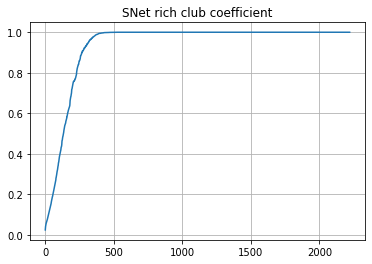

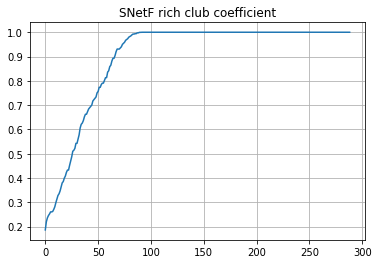

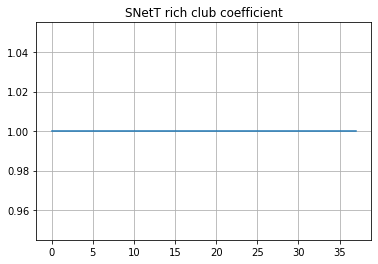

In [38]:
snet_rich_club_coefficient = nx.rich_club_coefficient(snet, normalized=False)
snetf_rich_club_coefficient = nx.rich_club_coefficient(snetf, normalized=False)
snett_rich_club_coefficient = nx.rich_club_coefficient(snett, normalized=False)

pd.DataFrame.from_dict(snet_rich_club_coefficient, orient="index").plot(title="SNet rich club coefficient", grid=True, legend=False)
pd.DataFrame.from_dict(snetf_rich_club_coefficient, orient="index").plot(title="SNetF rich club coefficient", grid=True, legend=False)
pd.DataFrame.from_dict(snett_rich_club_coefficient, orient="index").plot(title="SNetT rich club coefficient", grid=True, legend=False)

<AxesSubplot:xlabel='0', ylabel='1'>

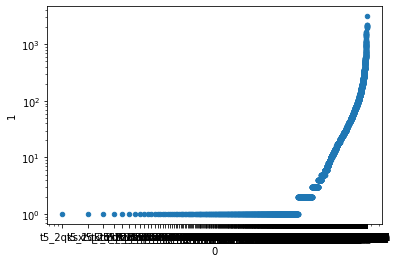

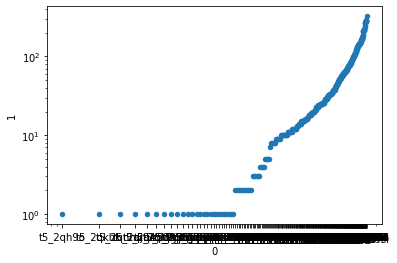

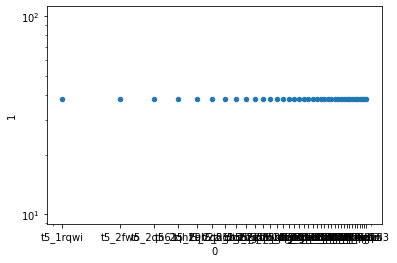

In [64]:
pd.DataFrame(snet.degree).sort_values(1).plot.scatter(x=0, y=1, legend=False, loglog=True)
pd.DataFrame(snetf.degree).sort_values(1).plot.scatter(x=0, y=1, legend=False, loglog=True)
pd.DataFrame(snett.degree).sort_values(1).plot.scatter(x=0, y=1, legend=False, loglog=True)